In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import plotly.graph_objects as go

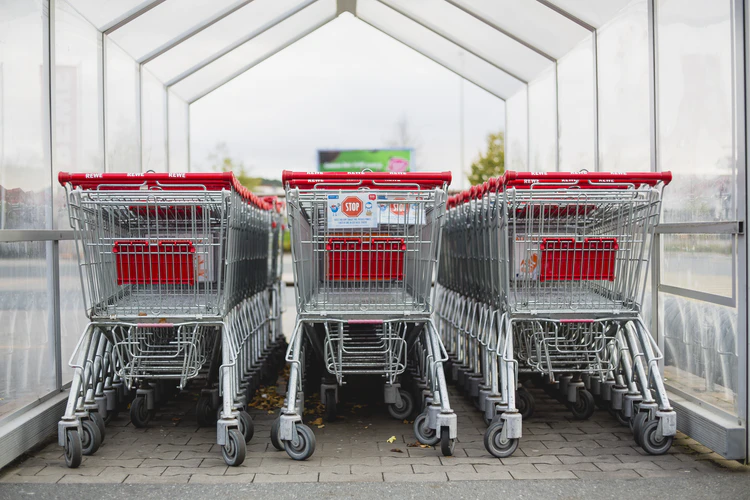
### This exploratory data analysis notebook will analyze the supermarket customer background and spending data and create customer segmentation using K-mean clustering.

## 1. Read CSV with Pandas

In [ ]:
customer_df = pd.read_csv("/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv")
customer_df.head()

In [ ]:
# shape of the dataset
print(customer_df.shape)

### Dataset description:

Currently, we have 200 entires of the supermarket customer demographic data. Here is a quick overview of the dataset columns:

1. CustomerID: the customer ID indexed by the membership system
2. Gender: the gender of the supermarket customer
3. Age: the age of the supermarket member
4. Annual Income (`k$`): the annual income of the customers with a unit of 1000 dollars
5. Spending Score (1-100): the spending score from 1-100. 100 means the customer is a active shopper

#### Is there any missing data?

In [ ]:
# my personal reusable function for detecting missing data
def missing_value_describe(data):
    # check missing values in the data
    missing_value_stats = (data.isnull().sum() / len(data)*100)
    missing_value_col_count = sum(missing_value_stats > 0)
    missing_value_stats = missing_value_stats.sort_values(ascending=False)[:missing_value_col_count]
    print("Number of columns with missing values:", missing_value_col_count)
    if missing_value_col_count != 0:
        # print out column names with missing value percentage
        print("\nMissing percentage (desceding):")
        print(missing_value_stats)
    else:
        print("No missing data!!!")
missing_value_describe(customer_df)

#### Great! We don't have missing data.

## 2. Exploratory data analysis of the member data

### 2.0 What's the distribution of the spending score?

In [ ]:
px.histogram(customer_df, y="Spending Score (1-100)", 
             marginal="rug", title="Spending score distribution")

### Observation:
From the spending score distribution histogram binned by increment of 10, we can see there are 3 spikes around spending score of 10-19, 40-49, and 70-79 with max count of 39 customers fall in to the spending score range of 40-49. The data is centered around the spending score range of 40-49.

### 2.1 What's the spending score distribution of the male and the female customers?

In [ ]:
customer_df.Gender.value_counts()

In [ ]:
px.box(customer_df, x="Spending Score (1-100)", y="Gender",
          color="Gender", points='all',
          title="Distribution of spending score by gender")

In [ ]:
# male customer spending score statistic summary
customer_df.query("Gender == 'Male'")["Spending Score (1-100)"].describe()

In [ ]:
# female customer spending score statistic summary
customer_df.query("Gender == 'Female'")["Spending Score (1-100)"].describe()

### Observation:
From the above visualizations, we can observe that there is no clear distinction between the medians and the top quantiles of the customer spending scores compared for the female and male customers. The 1st quantile of the male spending score is 10.5 unit lower than the 1st quantile of the female spending score. The max (99) of the spending scores for female is higher than the max (97) of the male spending scores. The min (5) of the spending scores for female is higher than the min (1) of the male spending scores. 

### 2.2 What are the spending score distributions of different age groups?

In [ ]:
px.histogram(customer_df, x="Age", title="Customer age distribution", nbins=10)

### Observation:
The distribution of the customer age data is relatively normal centered around the age range of 30-39 with total count of 61 customers.

In [ ]:
customer_df.Age.describe()

In [ ]:
# create a new column of age group with increment of 10 units
def bin_age(age):
    if age < 20: return "10-19"
    elif age < 30: return "20-29"
    elif age < 40: return "30-39"
    elif age < 50: return "40-49"
    elif age < 60: return "50-49"
    elif age < 70: return "60-69"
    else: return "70-79"

customer_df["age_group"] = customer_df.Age.apply(bin_age)

In [ ]:
customer_df["age_group"].unique()

In [ ]:
age_group_order = ['10-19', '20-29', '30-39', '40-49', '50-49', '60-69', '70-79']
px.box(customer_df, y="Spending Score (1-100)", x="age_group",
       title="Distribution of spending score by age group and gender group",
       color="Gender",
       category_orders={"age_group": age_group_order},
       facet_row="Gender")

### Observation:
From the above box plots, we can observe that the distributions of the two gender groups share similar pattern for the two age groups of 20-29 and 30-39. The median spending scores of 30-39 are the highest comparing to other age groups.

### 2.3 What are the annual income distributions of different age groups?

In [ ]:
age_group_order = ['10-19', '20-29', '30-39', '40-49', '50-49', '60-69', '70-79']
px.box(customer_df, y="Annual Income (k$)", x="age_group",
       title="Distribution of annual income by age group and gender group",
       color="Gender",
       category_orders={"age_group": age_group_order},
       facet_row="Gender")

### Observation:
From the above box plots, we can observe that the highest median annual income for male customers is 78K for age group of 30-39 and the highest medina annual income for female customers is 74K for age group of 30-39. The age group of 30-39 is also the age group with the highest spending score from the box plots in the previous section.

### 2.4 What are the correlations between the spending score, age, and income?

In [ ]:
customer_df.drop(["CustomerID"], axis=1).corr()

### Observation:
From the summary above, we can see the Pearson coefficients between different variables. We don't see strong linear correlation between the age, income, and the spending score. 

In [ ]:
px.scatter(customer_df, 
       x="Annual Income (k$)", y="Spending Score (1-100)", 
       color="Gender",
       hover_name="Spending Score (1-100)",
       title="Non-linear relationship between the annual income and spending score")

In [ ]:
px.scatter(customer_df, 
       x="Age", y="Spending Score (1-100)", 
       color="Gender",
       hover_name="Spending Score (1-100)",
       title="Non-linear relationship between the age and spending score")

### Observation:¶
From the above visualizations, we see non-linear relationship between the age, income, and the spending score. We can't just fit a linear model to model the spending score. However, we can use unsupervised clustering algorithm like K-mean to cluster the customer into different segments.

### 3. K-mean modeling for supermarket member segmentation

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

X = customer_df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]]

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 10))

visualizer.fit(X)  
visualizer.show();

#### Determining the k of k-mean for clustering:

I will use [elbow method](https://tinyurl.com/29a9m8yv) here: looks at the sum of intra-cluster distances, which is also referred to as inertia. Intra-cluster distance is the distance between each cluster center and the points within the cluster.

Where

$C_1, C_2, C_3$ are centroids
$P_i$s are points within that cluster
$distance$ is the usual Euclidean distance.

The inertia decreases as K increases. We can't just pick k that minimize the inertia because inertia can be minimize to 0 as k going to the size of the dataset.

> The intuition is that increasing the number of clusters will naturally improve the fit (explain more of the variation), since there are more parameters (more clusters) to use, but that at some point this is over-fitting, and the elbow reflects this.

### Observation:
From the above plot, we could argue that 4 clusters (the point of inflection on the curve) are enough.

In [ ]:
# fit kmean model with k=4
kmeans = KMeans(n_clusters=4, random_state=2)
kmeans.fit(X)
X["cluster"] = kmeans.predict(X)
X.head()

In [ ]:
# cluster centers
kmeans.cluster_centers_

#### Visualize the customer segmentations

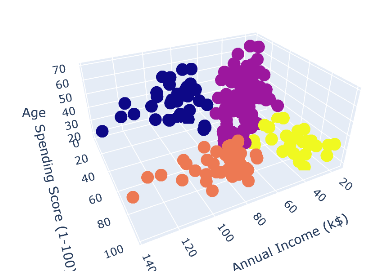

In [ ]:
px.scatter_3d(X, x="Annual Income (k$)", y="Spending Score (1-100)", z="Age",
                    color = 'cluster', title="Supermarket member segmentation")

### Let me break it down to 2D plots for further analysis.

In [ ]:
px.box(X, x="cluster", y="Annual Income (k$)",points='all', color="cluster",
          title="Distribution of annual income by cluster")

In [ ]:
px.box(X, x="cluster", y="Age",points='all', color="cluster",
          title="Distribution of customer age by cluster")

In [ ]:
px.box(X, x="cluster", y="Spending Score (1-100)",points='all', color="cluster",
          title="Distribution of spending score by cluster")

### Interpretation of the segmentation:

From the above K-mean clustering model results with the optimal k selected using elbow method, we can observe 4 interesting clusters colored by orange, blue, yellow, and purple.



Analyzing the clusters, we can see the what each cluster represent:
1. Cluster 0: customer group with median spendings core of 16.5, median annual income of 80K, and median age of 41.5.
2. Cluster 1: customer group with median spendings core of 74, median annual income of 28K, and median age of 23.
3. Cluster 2: customer group with median spendings core of 47, median annual income of 54K, and median age of 48.
4. Cluster 3: customer group with median spendings core of 83, median annual income of 79K, and median age of 32.

In other words regarding to the segmentation visualizations:
1. Cluster 0 customers are in their 40s, having high income, but spend frequently with low spending score.
2. Cluster 1 customers are in their 20s and don't have a lot of income and spend very frequently in the supermarket.
3. Cluster 2 customers are older custoemrs in their late 40 to 50s, having lower income than cluster 0 and spend less frequently.
4. Cluster 3 customers are in their 30s, having high come and spends most frequently in the supermarket.

In [ ]:
# number of customers in each cluster
pd.DataFrame(X.value_counts("cluster").reset_index(drop=True), columns=["customer count"])

### Observations:

From the cluster customer count, we can observe that we have higher cluster count of 95 in the cluster 0 segmentation which is people who are in their 40s with the high income people and spend less frequently.

### Suggestions:
Create marketing campaign targeting cluster 0 to increase the spending score to convert high income less frequent shoppers to more frequent shoppers.

### Thank you for reading all the way to here!
### Please give me an upvote if you enjoy reading this data analysis and modeling interpretation.

### If you like this one, check out other notebooks I have written:

* [Historic NBA Drafting, Game, and Player Analysis](https://www.kaggle.com/agilesifaka/historic-nba-drafting-game-and-player-analysis)
* [Analysis of Netflix Content Information](https://www.kaggle.com/agilesifaka/analysis-of-netflix-content-information)
* [Exploratory Analysis of Vancouver Crime Data](https://www.kaggle.com/agilesifaka/exploratory-analysis-of-vancouver-crime-data)